## Movielens

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path + 'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [4]:
movies = pd.read_csv(path + 'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [5]:
g = ratings.groupby('userId')['rating'].count()
topUsers = g.sort_values(ascending=False)[:15]

g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [6]:
val_idxs = get_cv_idxs(len(ratings))
wd = 2e-4
n_factors = 50

In [7]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [8]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.802578   0.80588   
    1      0.777764   0.780405                                  
    2      0.618335   0.765575                                  



[array([0.76558])]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [9]:
math.sqrt(0.776)

0.8809086218218096

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [10]:
preds = learn.predict()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


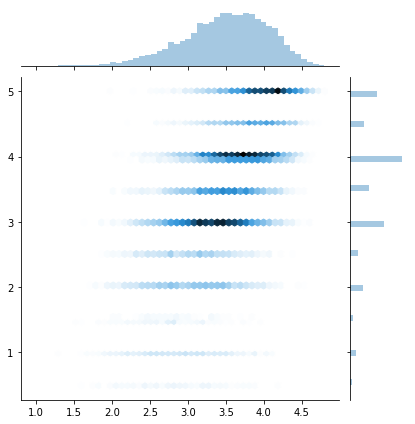

In [11]:
y = learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [12]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [13]:
m = learn.model
m.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [14]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [15]:
movie_bias

array([[0.79267],
       [0.95287],
       [1.33858],
       ...,
       [0.24086],
       [0.00687],
       [0.1862 ]], dtype=float32)

In [16]:
movie_ratings = [(b[0], movie_names[i]) for i, b in zip(topMovies, movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [17]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.9654783, 'Battlefield Earth (2000)'),
 (-0.7486593, 'Wild Wild West (1999)'),
 (-0.7136839, 'Speed 2: Cruise Control (1997)'),
 (-0.710915, 'Batman & Robin (1997)'),
 (-0.66560286, 'Flintstones, The (1994)'),
 (-0.6593919, 'Super Mario Bros. (1993)'),
 (-0.6521957, 'Dungeons & Dragons (2000)'),
 (-0.6514681, 'Anaconda (1997)'),
 (-0.6500837, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.6379982, "Joe's Apartment (1996)"),
 (-0.63213056, 'Haunting, The (1999)'),
 (-0.62925375, 'Bio-Dome (1996)'),
 (-0.6292327, 'Godzilla (1998)'),
 (-0.62757856, 'Inspector Gadget (1999)'),
 (-0.5964294, 'Superman III (1983)')]

In [18]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.3385832, 'Shawshank Redemption, The (1994)'),
 (1.1023588, 'Godfather, The (1972)'),
 (1.0544332, 'Usual Suspects, The (1995)'),
 (0.98509294, "Schindler's List (1993)"),
 (0.95287365, 'Pulp Fiction (1994)'),
 (0.9063378, 'Godfather: Part II, The (1974)'),
 (0.8960624, '12 Angry Men (1957)'),
 (0.8817619, 'Fargo (1996)'),
 (0.87886906, 'African Queen, The (1951)'),
 (0.87500596, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.8699101, 'Dark Knight, The (2008)'),
 (0.8604914, 'Matrix, The (1999)'),
 (0.85118383, 'Silence of the Lambs, The (1991)'),
 (0.84213996, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.8395255, 'To Kill a Mockingbird (1962)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [19]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [21]:
movie_pca.shape

(3, 3000)

In [22]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f, i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [23]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.08130365, 'Armageddon (1998)'),
 (0.068536215, 'Waterworld (1995)'),
 (0.063163035, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.057814635, 'Batman Forever (1995)'),
 (0.057495695, 'Mission: Impossible II (2000)'),
 (0.057204306, 'Lethal Weapon 4 (1998)'),
 (0.05613863, 'Pay It Forward (2000)'),
 (0.055517893, "Charlie's Angels (2000)"),
 (0.052707464, 'Outbreak (1995)'),
 (0.052406102, 'Lake Placid (1999)')]

In [24]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.088592246, 'Pulp Fiction (1994)'),
 (-0.07503895, 'Godfather, The (1972)'),
 (-0.06794521, 'Chinatown (1974)'),
 (-0.06712756, "One Flew Over the Cuckoo's Nest (1975)"),
 (-0.06504186, 'Fargo (1996)'),
 (-0.06424171, 'Apocalypse Now (1979)'),
 (-0.06187558, 'Full Metal Jacket (1987)'),
 (-0.060102902, 'Goodfellas (1990)'),
 (-0.05871792, 'Being John Malkovich (1999)'),
 (-0.058146175, 'This Is Spinal Tap (1984)')]

In [25]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [26]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.05334398, '8 1/2 (8½) (1963)'),
 (0.050121002, 'Mission to Mars (2000)'),
 (0.045871854, 'Brokeback Mountain (2005)'),
 (0.045580875, 'Home Alone 2: Lost in New York (1992)'),
 (0.045510445, 'Catwoman (2004)'),
 (0.045117103, 'Tank Girl (1995)'),
 (0.044080507, 'Transformers: Dark of the Moon (2011)'),
 (0.043967254, 'Avengers, The (1998)'),
 (0.04366053, 'Anaconda (1997)'),
 (0.04269051, 'Mr. Wrong (1996)')]

In [27]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.11018372, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.105354846, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.10278478, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.09862685, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.0954031, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.09284634, 'Matrix, The (1999)'),
 (-0.09054229, 'Spider-Man (2002)'),
 (-0.08486909, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.08446419,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.083501816, 'Shrek (2001)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

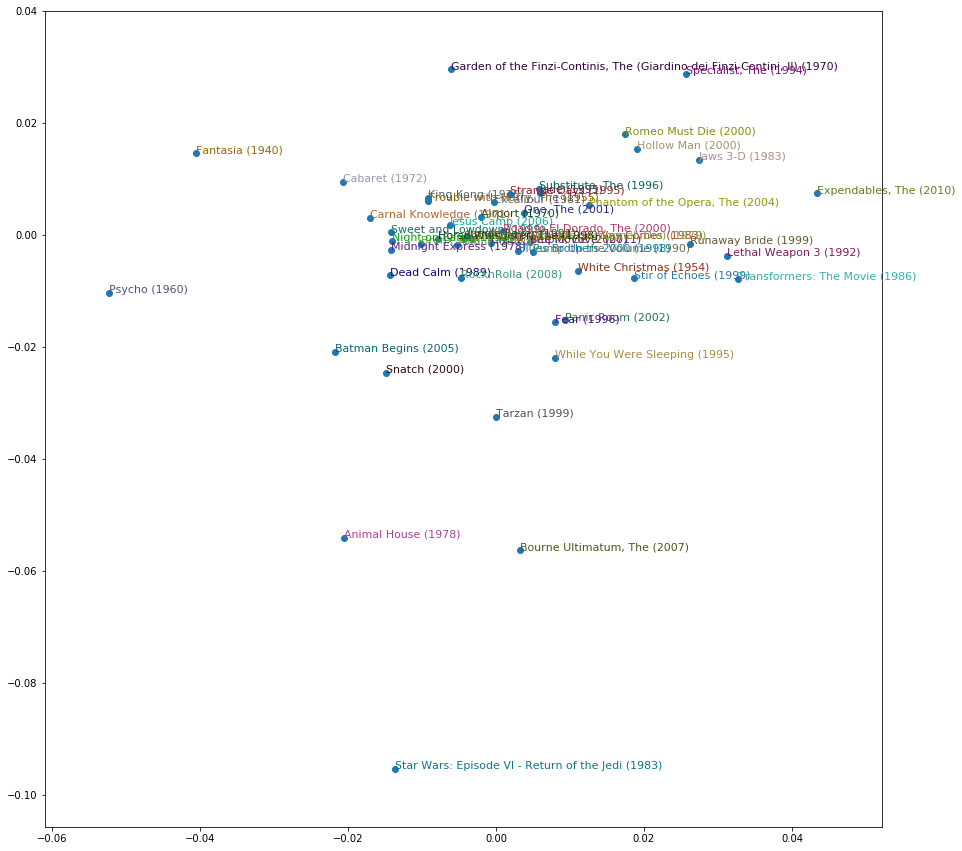

In [28]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3) * 0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [29]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a, b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [30]:
a * b


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [31]:
(a * b).sum(1)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [32]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u * m).sum(1)

In [33]:
model=DotProduct()

In [34]:
model(a, b)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

### Dot product model

In [35]:
u_uniq = ratings.userId.unique()
user2idx = {o: i for i, o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o: i for i, o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())

In [36]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0, 0.05)
        self.m.weight.data.uniform_(0, 0.05)
        
    def forward(self, cats, conts):
        users, movies = cats[:, 0],cats[:, 1]
        u, m = self.u(users), self.m(movies)
        return (u * m).sum(1)

In [37]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [38]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [39]:
wd = 1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [40]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      1.675747   1.631626  
    1      1.090123   1.301549                                 
    2      0.932382   1.213461                                  



[array([1.21346])]

In [41]:
set_lrs(opt, 0.01)

In [42]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.726431   1.145745  
    1      0.707382   1.134803                                  
    2      0.661197   1.129298                                  



[array([1.1293])]

### Bias

In [43]:
min_rating, max_rating = ratings.rating.min(), ratings.rating.max()
min_rating, max_rating

(0.5, 5.0)

In [44]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01, 0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:, 0], cats[:, 1]
        um = (self.u(users) * self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating - min_rating) + min_rating
        return res

In [45]:
wd = 2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [46]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.859378   0.839416  
    1      0.772442   0.81305                                   
    2      0.785252   0.809429                                  



[array([0.80943])]

In [47]:
set_lrs(opt, 1e-2)

In [48]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.767086   0.802531  
    1      0.734916   0.800935                                  
    2      0.730663   0.800853                                  



[array([0.80085])]

### Mini net

In [49]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors * 2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:, 0],cats[:, 1]
        x = self.drop1(torch.cat([self.u(users), self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating - min_rating + 1) + min_rating - 0.5

In [50]:
wd = 1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [51]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.889559   0.812058  
    1      0.827164   0.791009                                  
    2      0.784355   0.785319                                  



[array([0.78532])]

In [52]:
set_lrs(opt, 1e-3)

In [53]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.755579   0.788616  
    1      0.748564   0.790333                                  
    2      0.753161   0.788314                                  



[array([0.78831])]